In [1]:
from Environment import MazeEnvironment
from Agent import RatAgent
from maze_generator import maze_generator
from ExperienceReplay import ExperienceReplay
from policy_net import PolicyNet, Qloss
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 1. Load maze

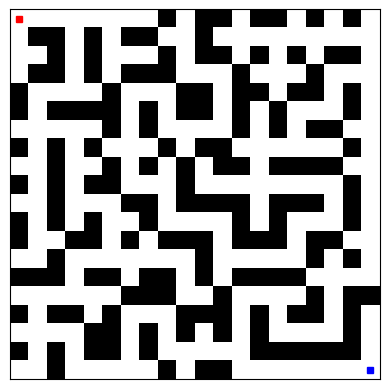

In [2]:
maze = np.load('maze_generator/maze.npy')

initial_position = [0,0]
goal = [len(maze)-1, len(maze)-1]

maze_env = MazeEnvironment(maze, initial_position, goal)
maze_env.draw()

# 2. Create Experience Replay memory

In [3]:
n_experiences_max = 10000
n_experiences_min = 1000
experiences = ExperienceReplay(capacity=n_experiences_max)

# 3. Create Rat Agent

In [4]:
rat = RatAgent(environment=maze_env, memory_buffer=experiences, n_actions=4)

# 4. Create Policy net

In [5]:
policy_net = PolicyNet(n_input_size=maze.size, n_actions=4, device=device)
optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)
batch_size = 32
gamma = 0.9

policy_net.to(device)

PolicyNet(
  (layerfc): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): ReLU()
  )
  (layerfc2): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): ReLU()
  )
  (layer_no_activation): Linear(in_features=400, out_features=4, bias=True)
)

In [6]:
n_epochs = 20000
cutoff = 2000

#Prioritize exploration more in the beginning
epsilon = np.exp(-np.arange(n_epochs)/(cutoff))
epsilon[epsilon > epsilon[100*int(n_epochs/cutoff)]] = epsilon[100*int(n_epochs/cutoff)]

In [7]:
win_count = 0
lose_count = 0
win_rate = 0
for epoch in range(n_epochs):
    loss = 0
    counter = 0
    current_epsilon = epsilon[epoch]
    rat.isgameon = True
    _ = rat.env.reset(current_epsilon)

    while rat.isgameon:
        rat.make_a_move(policy_net=policy_net, epsilon=current_epsilon, device=device)
        counter += 1

        if len(rat.experiences) < n_experiences_min:
            continue
        optimizer.zero_grad()
        batch = rat.experiences.get_sample(batch_size=batch_size, device=device)
        loss_t = Qloss(batch, policy_net = policy_net, gamma=gamma, device=device)
        loss_t.backward()
        optimizer.step()
        loss += loss_t.item()

    if(rat.env.current_position == rat.env.goal_position).all():
        result='won'
        win_count += 1
    else:
        result='lost'
        lose_count += 1
    if (epoch+1)%1000 == 0:
        rat.plot_policy_map(policy_net=policy_net, filename= "policy_epoch"+str(epoch+1)+".jpg", offset=[0.35,-0.3])
    if win_count > 0 or lose_count > 0:
        win_rate = win_count/(win_count+lose_count)
    print(f"Epoch: {epoch+1}/{n_epochs} | Loss = {loss:.4f} | Epsilon = {current_epsilon:.4f} |  Number of moves = {counter} | Win rate = {win_rate:.3f} | Wins = {win_count} | Loses = {lose_count}")
    clear_output(wait=True)
    if epoch > 10000 and win_count > 10*lose_count:
        if loss < 1e-3 and win_rate > 0.90:
            torch.save(policy_net.state_dict(), "best_policynet.torch")
            break

KeyboardInterrupt: 

In [ ]:
torch.save(policy_net.state_dict(), "policynet.torch")
policy_net.eval()
rat.isgameon = True
rat.use_softmax = False
_ = rat.env.reset(0)
while rat.isgameon:
    rat.make_a_move(policy_net, 0)
    rat.env.draw()
    clear_output(wait = True)